In [ ]:
from bincatsim.core import root
from matplotlib.pyplot import *
ion()
import numpy as np
from scipy.interpolate import griddata
from os import path

import re
import pandas as pd

join = path.join

fov1 = join(root.PSF_DATA_PATH, "FOV1_G0.p")
fov2 = join(root.PSF_DATA_PATH, "FOV2_G0.p")

def read_embedded_data(gp_path: str) -> pd.DataFrame:
    # Assume gnuplot script embeds data after a line starting with "plot" or "splot" referencing "-"
    # This will fail if the file has multiple datasets or unconventional formatting.
    with open(gp_path, "r") as fh:
        lines = fh.readlines()

    try:
        start = next(
            i for i, ln in enumerate(lines)
            if re.search(r'\bplot\b|\bsplot\b', ln) and "-" in ln
        ) + 1
    except StopIteration:
        raise ValueError(f"No embedded data found in {gp_path}; check file format.")

    data_lines = []
    for ln in lines[start:]:
        if ln.strip() in {"e", "end"}:  # gnuplot terminator
            break
        data_lines.append(ln)

    if not data_lines:
        raise ValueError(f"Embedded data section is empty in {gp_path}; verify the script.")

    # Adjust column names as needed; default to x y z ...
    df = pd.read_csv(pd.io.common.StringIO("".join(data_lines)), sep=r'\s+', header=None, names = ['AC','AL','Log(PSF)/px'])
    return df

df_fov1 = read_embedded_data(fov1)
df_fov2 = read_embedded_data(fov2)

(-9.844999999999999, 9.844999999999999, -6.545, 6.545)

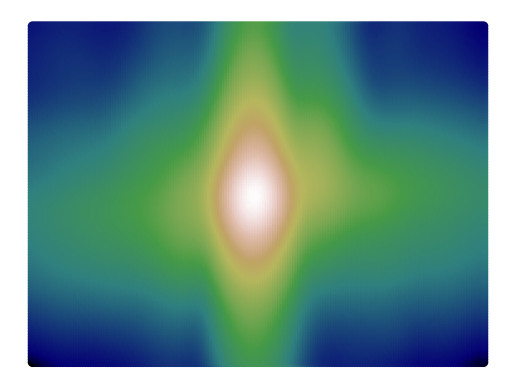

In [14]:
scatter(df_fov1['AL'], df_fov1['AC'], c=df_fov1['Log(PSF)/px'], cmap='gist_earth', marker='o', label='FOV1')
axis('off')

(-9.844999999999999, 9.844999999999999, -6.545, 6.545)

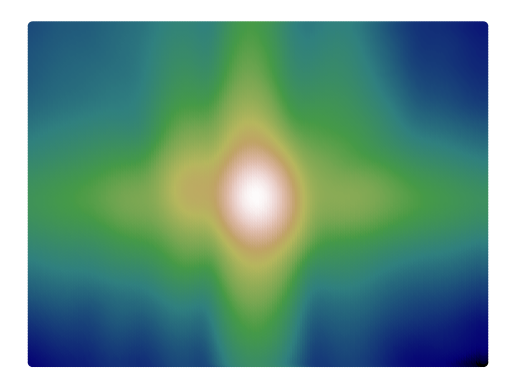

In [15]:
scatter(df_fov2['AL'], df_fov2['AC'], c=df_fov2['Log(PSF)/px'], cmap='gist_earth', marker='o', label='FOV2')
axis('off')

In [29]:
ac = np.linspace(df_fov1['AC'].min(), df_fov1['AC'].max(), 120)
al = np.linspace(df_fov1['AL'].min(), df_fov1['AL'].max(), 180)

In [50]:
AC,AL = np.meshgrid(ac, al, indexing='ij')

psf_1 = griddata((df_fov1['AC'], df_fov1['AL']), df_fov1['Log(PSF)/px'], 
                     (AC, AL), method='cubic')
psf_2 = griddata((df_fov2['AC'], df_fov2['AL']), df_fov2['Log(PSF)/px'], 
                     (AC, AL), method='cubic')

def plot_psf(PSF, ac, al, **kwargs):
    tit = kwargs.pop('title', 'True PSF')
    imshow(PSF, extent=(al.min(), al.max(), ac.min(), ac.max()), origin='lower', cmap='gist_earth', **kwargs)
    xlabel('AL [pix]')
    ylabel('AC [pix]')
    colorbar(label=r'Log(PSF) [pix$^{-1}$]')
    title(tit)

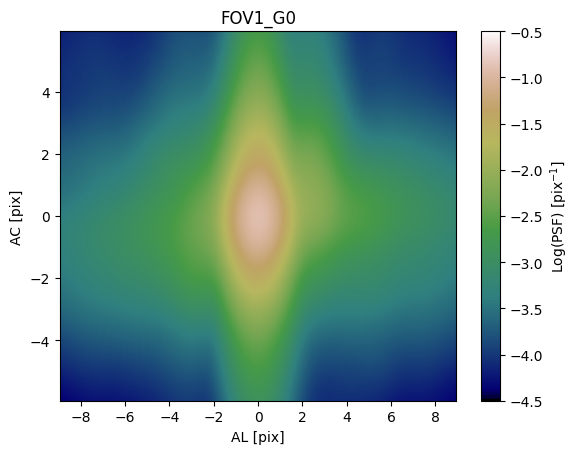

In [51]:
plot_psf(psf_1, ac, al, aspect='auto', vmax=-0.5, vmin=-4.5, title='FOV1_G0')

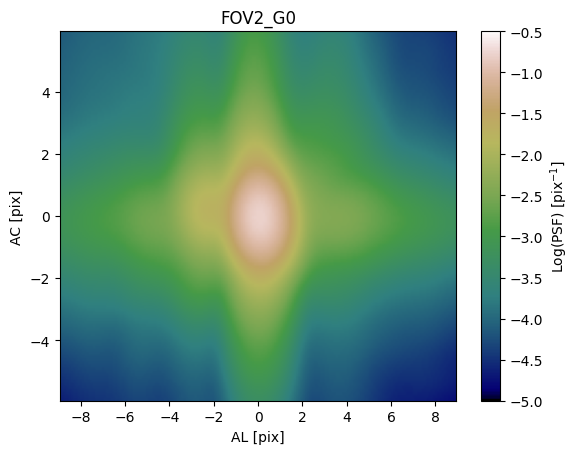

In [52]:
plot_psf(psf_2, ac, al, aspect='auto', vmax=-0.5, vmin=-5, title='FOV2_G0')